# Workshop 11: Introduction to Numerical ODE Solutions
*Source: Eric Ayars, PHYS 312 @ CSU Chico*


**Submit this notebook to bCourses to receive a grade for this Workshop.**

Please complete workshop activities in code cells in this iPython notebook. The activities titled **Practice** are purely for you to explore Python, and no particular output is expected. Some of them have some code written, and you should try to modify it in different ways to understand how it works. Although no particular output is expected at submission time, it is _highly_ recommended that you read and work through the practice activities before or alongside the exercises. However, the activities titled **Exercise** have specific tasks and specific outputs expected. Include comments in your code when necessary. Enter your name in the cell at the top of the notebook. 

**The workshop should be submitted on bCourses under the Assignments tab (both the .ipynb and .pdf files).**

In [1]:
# Run this cell before preceding
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Ordinary Differential Equation (ODE)

An ordinary differential equation is an equation that takes the following form:

$$F(t,x,x',x'',\dots) = 0$$

where $x$ is a function of $t$ and the $'$ symbol denotes derivatives:

$$x' = \frac{dx}{dt}$$
$$x'' = \frac{d^2x}{dt^2}$$
$$\vdots$$

An example is

$$x' + x = 0$$

To solve such an equation, we need to specify an *initial condition*: a set of values $(t_0, x_0)$ that our solution must pass through. This is because there are multiple solutions which can satisfy that equation. Any solution of the form 

$$x(t) = Ae^{-t}$$

satisfies the differential equation above. So by requiring that this curve pass through a particular point $(t_0, x_0)$, we can determine $A$:

$$A  = \frac{x_0}{e^{-t_0}}$$

Another way to visualize is this is with the aid of a "slope field": a plot that, for various points $(t,x)$ shows what $x(t)$ must look like locally by evaluating the derivative $x'$ at that point:

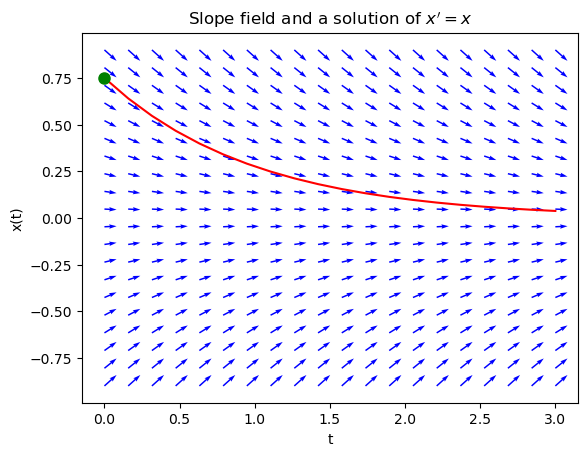

In [2]:
# Initial condition
t0 = 0.0
x0 = 0.75

# Make a grid of x,t values
t_values = np.linspace(t0, t0+3, 20)
x_values = np.linspace(-np.abs(x0)*1.2, np.abs(x0)*1.2, 20)
t, x = np.meshgrid(t_values, x_values)

# Evaluate derivative at each x point
xdot = -x

plt.figure()

# Plot slope field arrows
plt.quiver(t,x, np.ones(t.shape), xdot,color='b')

# Plot solution
A = x0 / np.exp(-t0)
plt.plot(t_values,A * np.exp(-t_values),color='r')

# Plot initial condition
plt.plot(t0,x0,'go',markersize=8)

plt.xlabel('t')
plt.ylabel('x(t)')
plt.title("Slope field and a solution of $x'=x$")
plt.show()

With those two pieces of information--the differential equation and an initial condition--we are able to write down a closed-form solution $x(t)$. But for a general differential equation, even if you have an initial condition, it is difficult to write down $x(t)$ in closed form. For example, if the equation is nonlinear or, if you have a set of *coupled* differential equations, as we frequently encounter in physics, numerical methods are indispensable.

## Outline of this Workshop

1. Basic setup and numerical solution of a first-order ODE
2. Set up a second-order ODE--the harmonic oscillator
3. Numerical stability issue
4. Phase portraits

## Euler method

### Definition of the Euler method

Suppose we have the differential equation

$$\frac{dx}{dt} = f(x,t)$$

This means that, given a point in the system $(x_0, t_0)$, we have a way to compute the derivative $dx/dt$ at that point. But it may be difficult or impossible to analytically integrate $f(x,t)$ to find a closed form for $x(t)$. Instead, we rely on numerical methods to estimate solutions. More specifically, given an *initial condition* $(x_0, t_0)$, where $x(t_0) = x_0$, the goal is to find a numerical method to calculate $x(t)$ for $t > t_0$. 

The most basic Euler method is based on the simple observation that

$$x(t+\Delta t) = x(t) + \int_{t}^{t+\Delta t} \left(\frac{dx}{dt}\right) dt =  x(t) + \int_{t}^{t+\Delta t} f(x(t),t) dt $$

If we cannot explicitly take that integral, but we have a way to calculate $f(x,t)$, then the first thing we would try is 

$$x(t+\Delta t) \approx x(t) + f(x(t), t) \cdot \Delta t$$

Now let us try to make this into code. Suppose we have a list of times $\{t_i\}$ such that $t_{i+1} - t_i = \Delta t$ (generated by `np.arange` or `np.linspace`, for example). Then given $x_0$ at $t_0$, we calculate $x_i$ according to the rule

$$x_i = x_{i-1} + f(x_{i-1},t_{i-1})\Delta t$$

So as long as we can write the first derivative in the form above, we have a way to attack this problem. 

For example, we can numerically solve a problem like

$$v' = 1-v^2$$
$$\rightarrow v_i = v_{i-1} + f(v_{i-1}, t_{i-1}) \Delta t = v_{i-1} + (1-v_{i-1}^2)\Delta t$$
Given an initial $(t_0, v_0)$, we can use the Euler method to solve this equation, which describes the velocity (denoted $v$ here) of a particle falling but experiencing a drag force (see lecture). We know that the solution of such an equation should be that the velocity of the particle should increase quickly at first (due to constant gravitational force) but then asymptote to some terminal value because the drag force increases with velocity. Let's see this:

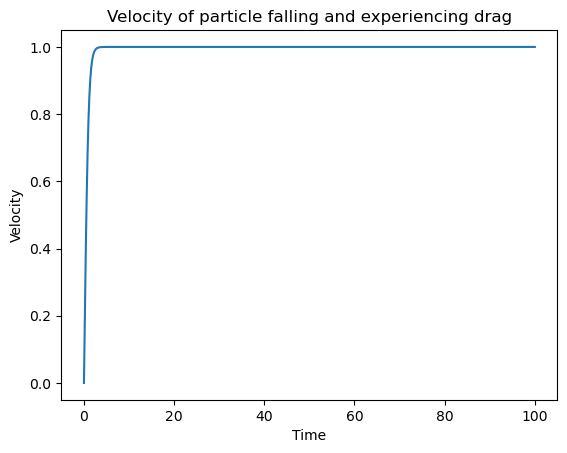

In [3]:
# Basic example of Euler method
t_0 = 0.0 # initial time condition
v_0 = 0.0 # initial velocity condition

# Generate some times t_i
t_data = np.linspace(0,100,1000)

# Placeholder array for velocities v_i
v_data = np.zeros(1000)

v_data[0] = v_0
N = len(t_data)

# use Euler method to estimate v_i for each i
for i in range(1,N):
    
    f = 1 - v_data[i-1]**2 # f(v_{i-1})
    dt = t_data[i] - t_data[i-1] # time interval
    v_data[i] = v_data[i-1] + f * dt # calculate v_i

# Plot results
plt.figure()
plt.plot(t_data, v_data)
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.title("Velocity of particle falling and experiencing drag")
plt.show()

So we have established a technique to approximate solutions to some first-order differential equations. Note that these solutions still have some error--flip back to the workshop on integration techniques to remind yourself of this.

At first, being able to solve only first-order differential equations seems very restrictive. But actually, it is enough for us to start modeling real systems and observing interesting behaviors. First, let us try to convert a second order differential equation, such as Newton's second law, into a set of first order differential equations, which we now know how to solve.

### Example: Euler Method and a Second-Order ODE

Commonly we have a set of *second-order* differential equations. For example, the harmonic oscillator takes this form:

$$F = ma = m\frac{d^2x}{dt^2} = -kx$$
$$\rightarrow \frac{d^2x}{dt^2} + \frac{k}{m}x = 0$$
But we can rewrite as a set of first-order differential equations by noting that

$$a = \frac{dv}{dt}$$

and

$$v = \frac{dx}{dt}$$

So the force equation above becomes a pair of equations:

\begin{align}
x' &= \frac{dx}{dt} =  v \\
v' &= \frac{dv}{dt} = -\frac{k}{m}x
\end{align}

This means that to form a solution, we need three numbers for the initial condition, $(t_0, x_0, v_0)$ where $x(t_0) = x_0$ and $v(t_0) = v_0$. As we did above, let us write this down in terms of the values $x_i$, $v_i$, and $t_i$:

\begin{align}
x_i &= x_{i-1} + v_{i-1} \Delta t \\
v_i &= v_{i-1} + \left(-\frac{k}{m}x_{i-1}\right)\Delta t
\end{align}

In the examples below, I will continue to take $t_0 = 0$

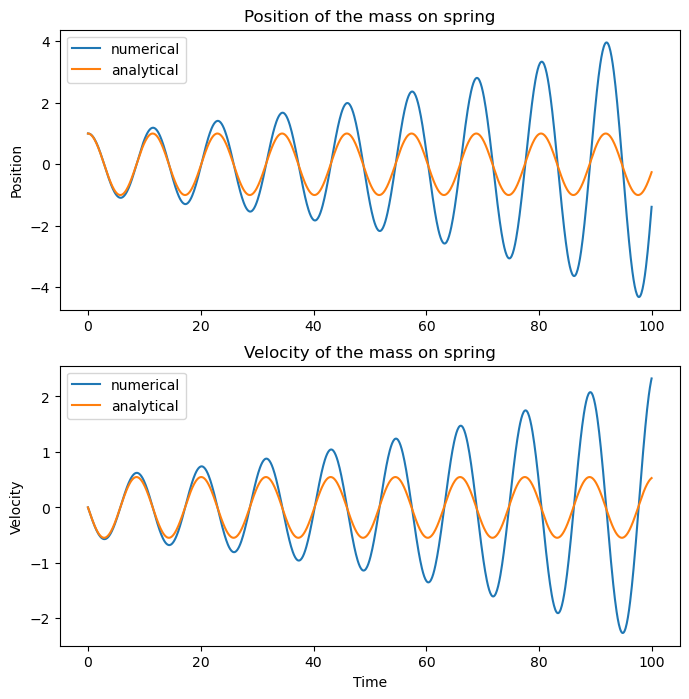

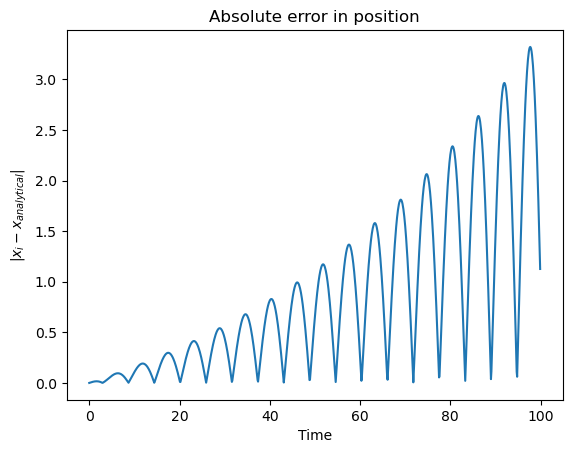

In [4]:
# Use Euler method to solve coupled first order ODE
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

km = 0.3 # value of k / m

# Initial conditions
x_0 = 1.0
v_0 = 0.0

# Number of timesteps
T = 1000
dt = 0.1 #size of time step (Delta t)


def Euler(t0, x0, v0, T, dt):
    x_data = np.zeros(T)
    v_data = np.zeros(T)
    
    t_data = np.arange(T) * dt + t0
    x_data[0] = x0
    v_data[0] = v0
    
    
    for i in range(1,T):
        x_data[i] = x_data[i-1] + v_data[i-1] * dt
        v_data[i] = v_data[i-1] + (-km * x_data[i-1]) * dt
        
    return t_data, x_data, v_data

t_data, x_data, v_data = Euler(0.0, x_0, v_0, T, dt)

# Analytical solutions for (x(t), v(t)) assuming x_0 = 1.0, v_0 = 0, t_0 = 0
analytical_x = np.cos(np.sqrt(km)*t_data)
analytical_v = -np.sqrt(km)*np.sin(np.sqrt(km)*t_data)

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(t_data, x_data, label="numerical")
plt.plot(t_data, analytical_x,label="analytical")
plt.ylabel("Position")
plt.legend()
plt.title("Position of the mass on spring")

plt.subplot(212)
plt.plot(t_data, v_data, label="numerical")
plt.plot(t_data, analytical_v, label="analytical")
plt.ylabel("Velocity")
plt.xlabel("Time")
plt.legend()
plt.title("Velocity of the mass on spring")

# Plot error in position as a function of time
plt.figure()
plt.plot(t_data, np.abs(x_data - analytical_x))
plt.ylabel("$|x_i - x_{analytical}|$")
plt.xlabel("Time")
plt.title("Absolute error in position")
plt.show()

### Exercise 1:

The damped harmonic oscillator (DHO) satisfies the following differential equation:

$$\frac{d^2x}{dt^2}+\frac{c}{m}\frac{dx}{dt}+\frac{k}{m}x = 0$$

It differs from the previous example by the addition of the $(c/m) dx/dt$ term. Like we did above, we can unwrap this second-order ODE into two first-order ODEs using two separate variables $x(t)$ and $v(t)$

\begin{align}
x' &= v \\
v' &= -\frac{c}{m}v - \frac{k}{m}x
\end{align}

1. Like in the example above, write down the update rules for $x_i$ and $v_i$. 
1. Then write some code to implement your rules to estimate a numerical solution for $x(t)$ and $v(t)$ for a given initial condition $x_0$ and $v_0$ (you can assume $t_0 = 0$ like above). 
1. Plot your results for $x(t)$ and $v(t)$ and make sure that they make sense. You may use the code in the example as a template.

*Hint*: Recall that the qualitative behavior of the oscillator is different depending on the (dimensionless) value of the ratio 

$$\frac{(c/m)^2}{k/m}$$

So you should be able to see the effect of this by trying out different values for $c/m$ and $k/m$.

Update rules:
$$x_i=x_{i-1}+v_{i-1}\Delta t$$
$$v_i=v_{i-1}+(-\frac{c}{m}v_{i-1}-\frac{k}{m}x_{i-1})\Delta t$$

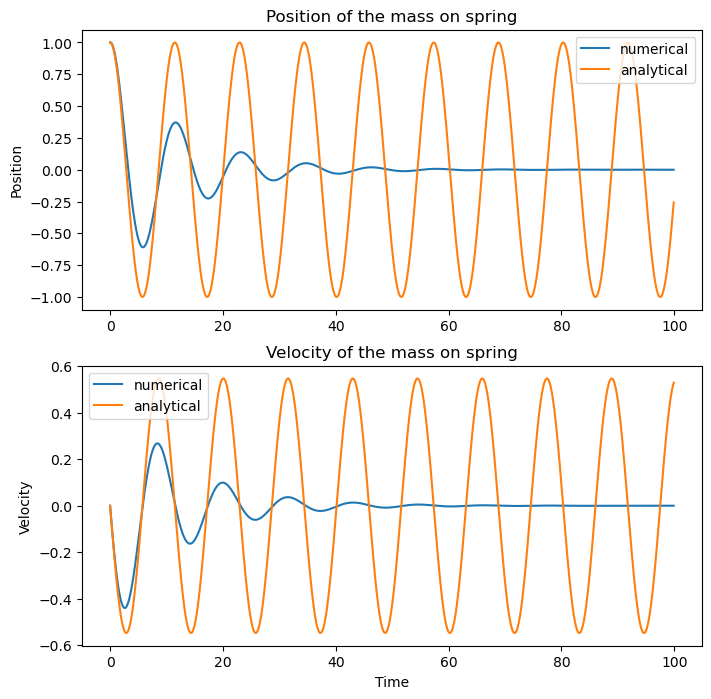

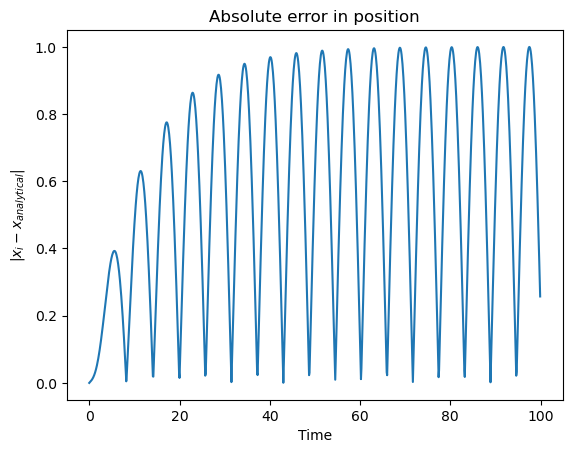

In [5]:
# Code for Exercise 1
# Use Euler method to solve coupled first order ODE
cm = 0.2 # value of c / m
km = 0.3 # value of k / m

# Initial conditions
x_0 = 1.0
v_0 = 0.0

# Number of timesteps
T = 1000
dt = 0.1 #size of time step (Delta t)


def Euler(t0, x0, v0, T, dt):
    x_data = np.zeros(T)
    v_data = np.zeros(T)
    
    t_data = np.arange(T) * dt + t0
    x_data[0] = x0
    v_data[0] = v0
    
    
    for i in range(1,T):
        x_data[i] = x_data[i-1] + v_data[i-1] * dt
        v_data[i] = v_data[i-1] + (-cm * v_data[i-1] - km * x_data[i-1]) * dt
        
    return t_data, x_data, v_data

t_data, x_data, v_data = Euler(0.0, x_0, v_0, T, dt)

# Analytical solutions for (x(t), v(t)) assuming x_0 = 1.0, v_0 = 0, t_0 = 0
analytical_x = np.cos(np.sqrt(km)*t_data)
analytical_v = -np.sqrt(km)*np.sin(np.sqrt(km)*t_data)

plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(t_data, x_data, label="numerical")
plt.plot(t_data, analytical_x,label="analytical")
plt.ylabel("Position")
plt.legend()
plt.title("Position of the mass on spring")

plt.subplot(212)
plt.plot(t_data, v_data, label="numerical")
plt.plot(t_data, analytical_v, label="analytical")
plt.ylabel("Velocity")
plt.xlabel("Time")
plt.legend()
plt.title("Velocity of the mass on spring")

# Plot error in position as a function of time
plt.figure()
plt.plot(t_data, np.abs(x_data - analytical_x))
plt.ylabel("$|x_i - x_{analytical}|$")
plt.xlabel("Time")
plt.title("Absolute error in position")
plt.show()

## But wait...

But you know that for a closed system, like the SHO, we actually have a special constraint on the system--the total energy (kinetic + potential) must be constant! So at every point of our solution, we should check whether this is true. How do we evaluate the total energy?

$$E = T + U = \frac{1}{2}mv^2 + \frac{1}{2}kx^2$$

Let's define a rescaled energy $\tilde{E}$ as $(1/m)E$:

$$\tilde{E} = \frac{1}{2}v^2 + \frac{1}{2}\frac{k}{m} x^2$$

### Exercise 2:

1. Copy the code from the example using the SHO above, in which we solved the SHO using the Euler Method. Add code to calculate the rescaled energy $\tilde{E}_i$ for each time step.
1. Plot $\tilde{E}(t)$ vs. the time. Does the energy stay constant, fluctuate around some constant value, or does it diverge/decay?

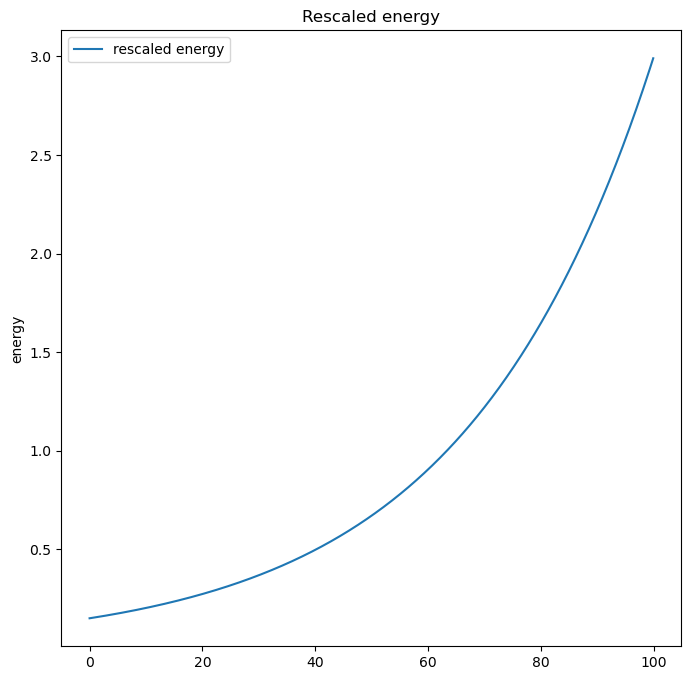

The energy diverges.


In [6]:
# Code for Exercise 2
# Use Euler method to solve coupled first order ODE
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

km = 0.3 # value of k / m

# Initial conditions
x_0 = 1.0
v_0 = 0.0

# Number of timesteps
T = 1000
dt = 0.1 #size of time step (Delta t)


def Euler(t0, x0, v0, T, dt):
    x_data = np.zeros(T)
    v_data = np.zeros(T)
    
    t_data = np.arange(T) * dt + t0
    x_data[0] = x0
    v_data[0] = v0
    
    
    for i in range(1,T):
        x_data[i] = x_data[i-1] + v_data[i-1] * dt
        v_data[i] = v_data[i-1] + (-km * x_data[i-1]) * dt
        
    return t_data, x_data, v_data


def Rescaled_Energy(x, v):
    return v ** 2 / 2 + km * x ** 2 / 2

t_data, x_data, v_data = Euler(0.0, x_0, v_0, T, dt)
e_data = Rescaled_Energy(x_data, v_data)

plt.figure(figsize=(8,8))
plt.plot(t_data, e_data, label="rescaled energy")
plt.ylabel("energy")
plt.legend()
plt.title("Rescaled energy")
plt.show()

print('The energy diverges.')

## Euler-Cromer/Symplectic Euler Method

There exists a way to keep the energy fluctuations from growing, using a just a slight variant of the update rules described above. This update rule is called the 

\begin{align}
v_i &= v_{i-1} + \left(-\frac{k}{m}x_{i-1}\right)\Delta t \\
x_i &= x_{i-1} + v_{i} \Delta t
\end{align}

In this version, you use the approximate velocity at time $t_i$ instead of the velocity at time $t_{i-1}$ to calculate $x_i$.

### Exercise 3:

1. Modify the code from Exercise 2 to instead implement the update rule in the Euler-Cromer method. You can either modify the it in-place or copy it to the cell below and modify it.
1. Now run your code to calculate and plot $x(t)$, $v(t)$, and $\tilde{E}(t)$. Does the energy stay constant, fluctuate around some constant value, or does it diverge/decay?

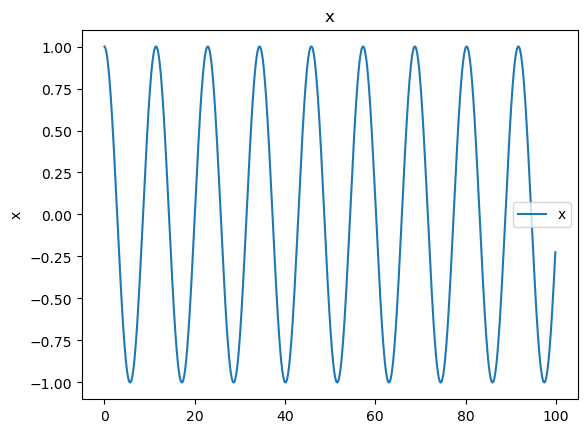

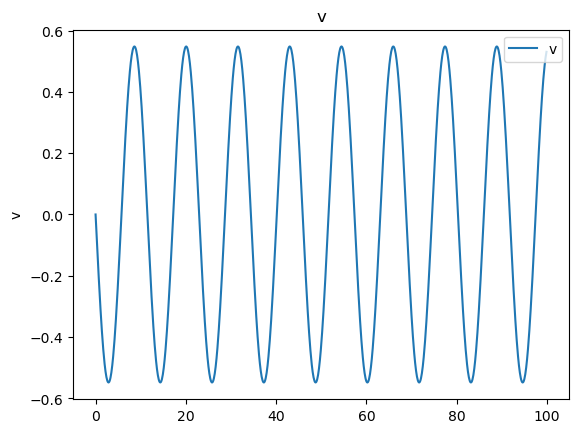

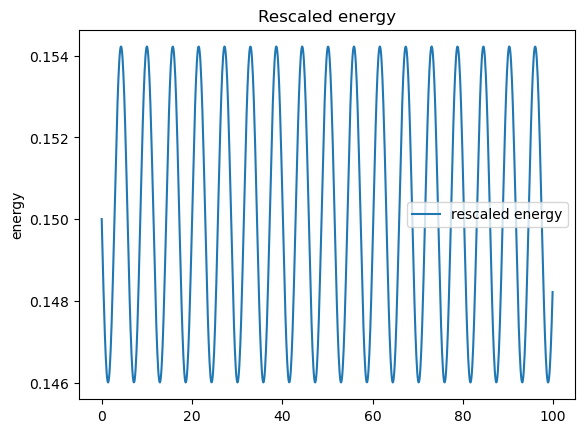

The energy fluctuates around some constant value.


In [7]:
# Code for Exercise 3
# Use Euler method to solve coupled first order ODE
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

km = 0.3 # value of k / m

# Initial conditions
x_0 = 1.0
v_0 = 0.0

# Number of timesteps
T = 1000
dt = 0.1 #size of time step (Delta t)


def Euler(t0, x0, v0, T, dt):
    x_data = np.zeros(T)
    v_data = np.zeros(T)
    
    t_data = np.arange(T) * dt + t0
    x_data[0] = x0
    v_data[0] = v0
    
    
    for i in range(1,T):
        v_data[i] = v_data[i-1] + (-km * x_data[i-1]) * dt
        x_data[i] = x_data[i-1] + v_data[i] * dt    
        
    return t_data, x_data, v_data


def Rescaled_Energy(x, v):
    return v ** 2 / 2 + km * x ** 2 / 2

t_data, x_data, v_data = Euler(0.0, x_0, v_0, T, dt)
e_data = Rescaled_Energy(x_data, v_data)

# Analytical solutions for (x(t), v(t)) assuming x_0 = 1.0, v_0 = 0, t_0 = 0
plt.figure()
plt.plot(t_data, x_data, label="x")
plt.ylabel("x")
plt.legend()
plt.title("x")
plt.show()

plt.figure()
plt.plot(t_data, v_data, label="v")
plt.ylabel("v")
plt.legend()
plt.title("v")
plt.show()

plt.figure()
plt.plot(t_data, e_data, label="rescaled energy")
plt.ylabel("energy")
plt.legend()
plt.title("Rescaled energy")
plt.show()

print('The energy fluctuates around some constant value.')

There are also higher order ODE integration schemes, like Runge-Kutta, which make better estimates of the change in $(x(t),v(t)...)$ between $t_{i-1}$ and $t_i$. The shortcoming of our simple method above is that we are typically using the value of the derivative ($x'$ or $v'$) at $t_i$ or $t_{i-1}$ as a subsitute for the derivative over the entire interval $(t_{i-1}, t_i)$. These higher order schemes try to make better estimates of the derivatives inside this interval to make a better estimate of $\Delta x$ and $\Delta v$.

## Visualizing Phase Space

Here we generalize the use of the slope field above to visualize our error in the Euler method. The tool below is called a phase portrait and is ubiquitous in physics and mathematics, and students studying dynamical systems for their capstone projects may find it useful as a nice visualization. In the cell below, we examine the phase portrait of the SHO and study the numerical and analytical solutions. Before you run this cell, run the SHO example cell again with `x_0 = 1.0` and `v_0 = 0.0` so that `km`, `x_data`, and `v_data` are properly populated. 

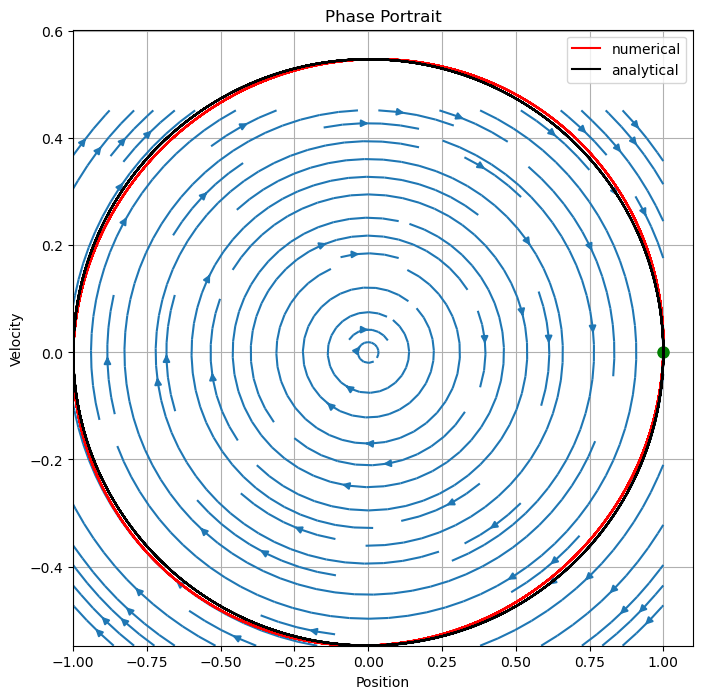

In [8]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

xvalues, yvalues = np.meshgrid(np.arange(min(x_data),max(x_data), 0.2), np.arange(min(v_data), max(v_data), 0.5))
xdot = yvalues
ydot = - km * xvalues

plt.figure(figsize=(8,8))
plt.streamplot(xvalues, yvalues, xdot, ydot)

plt.plot(x_data[0],v_data[0],'go',markersize=8)
plt.plot(x_data, v_data,color='r', label="numerical")
plt.plot(analytical_x, analytical_v, color='k', label="analytical")
plt.ylabel("Velocity")
plt.xlabel("Position")
plt.title("Phase Portrait")
plt.legend()
plt.grid()
plt.show()

You can make phase portraits for just about any system! Here's a phase portrait for the DHO. How does the phase portrait change qualitatively, as you vary $c/m$ and $k/m$?

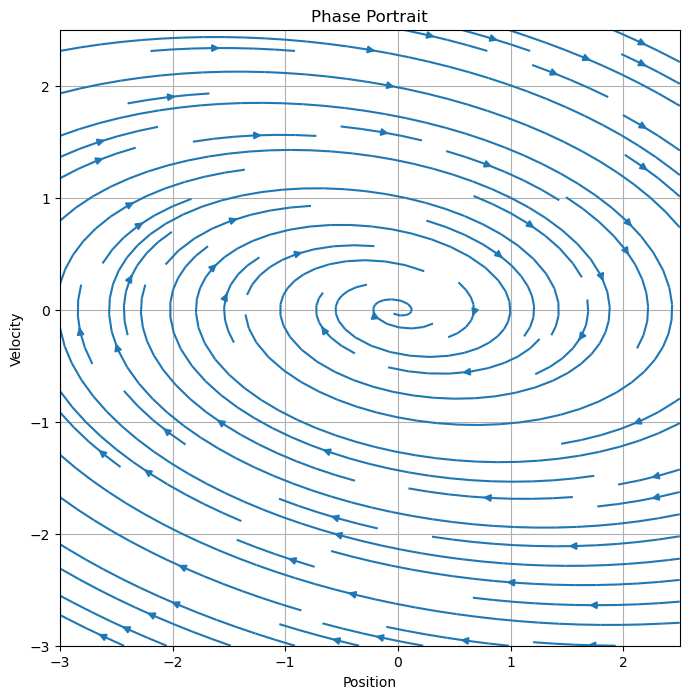

In [9]:
cm = 0.2 # c / m
km = 0.3 # k / m

xvalues, yvalues = np.meshgrid(np.arange(-3,3, 0.5), np.arange(-3,3, 0.5))
xdot = yvalues
ydot = - cm * yvalues - km * xvalues

plt.figure(figsize=(8,8))
plt.streamplot(xvalues, yvalues, xdot, ydot)

plt.ylabel("Velocity")
plt.xlabel("Position")
plt.title("Phase Portrait")
plt.grid()
plt.show()